# Chapter 7: k-Nearest Neighbors (k-NN)


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - pandas: 1.0.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [1]:
# Import required packages for this chapter
from pathlib import Path
import math

import pandas as pd

from sklearn.metrics import pairwise
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor #, NearestNeighbors

%matplotlib inline

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('.')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

# Problem 7.1 Calculating Distance with Categorical Predictors 

This exercise with a tiny dataset illustrates the calculation of Euclidean distance, and the creation of binary dummies. The online education company Statistics.com segments its customers and prospects into three main categories: IT professionals (IT), statisticians (Stat), and other (Other). It also tracks, for each customer, the number of years since first contact (years). Consider the following customers; information about whether they have taken a course or not (the outcome to be predicted) is included:

Customer 1: Stat, 1 year, did not take course

Customer 2: Other, 1.1 year, took course

__7.1.a__ Consider now the following new prospect:

Prospect 1: IT, 1 year

Using the above information on the two customers and one prospect, create one dataset for all three with the categorical predictor variable transformed into 2 binaries, and a similar dataset with the categorical predictor variable transformed into 3
binaries.

__7.1.b.__ For each derived dataset, calculate the Euclidean distance between the prospect and each of the other two customers. (Note: while it is typical to normalize data for k-NN, this is not an iron-clad rule and you may proceed here without normalization.)

__7.1.c.__ Using k-NN with k = 1, classify the prospect as taking or not taking a course using each of the two derived datasets. Does it make a difference whether you use 2 or 3 dummies?

__Answer:__

In [3]:
# create a data frame, containing the following columns
# column 'Name" containing customer names, i.e. Customer1, Customer2 and Cistomer3.
# columns 'Stat', 'Other' and 'IT' as three dummies for three main categories of customers. 
# column 'TookCourse' containing whether that customer took the course or not, where 1 indicates a course taken and 0 otherwise.
data = [['Customer1', 1, 0, 0, 1, 0], ['Customer2', 0, 1, 0, 1.1, 1], ['Customer3', 0, 0, 1, 1]]
df = pd.DataFrame(data,columns=['Name','Stat','Other', 'IT', 'Years', 'CourseTaken'])
print (df)

        Name  Stat  Other  IT  Years  CourseTaken
0  Customer1     1      0   0    1.0          0.0
1  Customer2     0      1   0    1.1          1.0
2  Customer3     0      0   1    1.0          NaN


Note that Customer3 is the new prospect.

In [4]:
# calculate euclidean distances between customers 1 and 3 and customers 2 and 3 using two dummies.
# drop the dummy 'Other'
col = ['Stat', 'IT', 'Years']
df2dummies = df[col]
d = pairwise.pairwise_distances(df2dummies, metric='euclidean')
# prettify distance matrix by converting to a dataframe
pd.DataFrame(d, columns=df.Name, index=df.Name)

Name,Customer1,Customer2,Customer3
Name,,,
Customer1,0.000000,1.004988,1.414214
Customer2,1.004988,0.000000,1.004988
Customer3,1.414214,1.004988,0.000000


If we use two dummies, the prospect (Customer3) is closest to Customer 2. in this case Euclidean distance between the prospect and the second customer is less than the euclidean distance between the prospect and the first customer. Therefore we classify the new customer as taking the course.

In [5]:
# calculate euclidean distances between customers 1 and 3 and customers 2 and 3 using all three dummies.
from sklearn.metrics import pairwise
# use only relevant columns
col = ['Stat', 'Other', 'IT', 'Years']
df3dummies = df[col]
d = pairwise.pairwise_distances(df3dummies, metric='euclidean')
# prettify distance matrix by converting to a dataframe
pd.DataFrame(d, columns=df.Name, index=df.Name)

Name,Customer1,Customer2,Customer3
Name,,,
Customer1,0.000000,1.417745,1.414214
Customer2,1.417745,0.000000,1.417745
Customer3,1.414214,1.417745,0.000000


If we use all three dummies, the prospect (Customer3) is closest to Customer1. In this case the euclidean distance between the prospect and the first customer is less than the euclidean distance between the prospect and the second customer. Therefore we classify the new customer as "not taking the course".

# Problem 7.2 Personal Loan Acceptance

Universal Bank is a relatively young bank growing rapidly in terms of overall customer acquisition. The majority of these customers are liability customers (depositors) with varying sizes of relationship with the bank. The customer base of asset customers (borrowers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business. In particular, it wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise smarter campaigns with better target marketing. The goal is to use
k-NN to predict whether a new customer will accept a loan offer. This will serve as the basis for the design of a new campaign.

The file _UniversalBank.csv_ contains data on 5000 customers. The data include customer demographic information (age, income, etc.), the customer’s relationship with the bank (mortgage, securities account, etc.), and the customer response to the last personal loan campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6%) accepted the personal loan that was offered to them in the earlier campaign.

Partition the data into training (60%) and validation (40%) sets.

__7.2.a__ Consider the following customer:

Age = 40, Experience = 10, Income = 84, Family = 2, CCAvg = 2, Education_1= 0, Education_2 = 1, Education_3 = 0, Mortgage = 0, Securities Account = 0, CD Account = 0, Online = 1, and Credit Card = 1. Perform a k-NN classification with all predictors except ID and ZIP code using k = 1. Remember to transform categorical predictors with more than two categories into dummy variables first. Specify the success class as 1 (loan acceptance), and use the default cutoff value of 0.5. How would this customer be classified?

__Answer:__ 

#### Data preparation
Load the data and remove unnecessary columns (ID, ZIP Code). Split the data into training (60%) and validation (40%) sets (use `random_state=1`).

In [6]:
# Load the data
bank_df = pd.read_csv(DATA / 'UniversalBank.csv')

# Drop ID and zip code columns
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

# Make sure that the result is as expected
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [7]:
# modify column names
bank_df.columns = [c.replace(' ', '_').replace('=', '_') for c in bank_df.columns]
list(bank_df.columns)

['Age',
 'Experience',
 'Income',
 'Family',
 'CCAvg',
 'Education',
 'Mortgage',
 'Personal_Loan',
 'Securities_Account',
 'CD_Account',
 'Online',
 'CreditCard']

In [8]:
# create dummy variables for categorical variable, we consider Education as categorical variable
bank_df['Education'] = bank_df['Education'].astype('category')
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=False)
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,25,1,49,4,1.6,0,0,1,0,0,0,1,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,1,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,1,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,0,1,0


In [9]:
# split dataset into training (60%) and validation (40%) sets
train_df, valid_df = train_test_split(bank_df, test_size=0.4, random_state=1)
print('Training set:', train_df.shape, 'Validation set:', valid_df.shape)

Training set: (3000, 14) Validation set: (2000, 14)


In [10]:
# new customer
newCustomer = pd.DataFrame([{'Age': 40, 'Experience': 10, 'Income': 84, 'Family': 2, 'CCAvg': 2, 'Mortgage': 0,
                             'Securities_Account': 0, 'CD_Account': 0, 'Online': 1, 'CreditCard': 1, 'Education_1': 0, 
                             'Education_2': 1, 'Education_3': 0}],
                            columns=['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account',
                                   'CD_Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3'])
newCustomer

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,40,10,84,2,2,0,0,0,1,1,0,1,0


In [11]:
# normalize training and validation sets. The transformation is trained using the training set only.
# if you don't convert the integer columns to real numbers (float64), 
# the StandardScaler will raise a DataConversionWarning. This is expected
outcome = 'Personal_Loan'
predictors = list(bank_df.columns)
predictors.remove(outcome)

scaler = preprocessing.StandardScaler()
scaler.fit(train_df[predictors])
scaler.transform(train_df[predictors])
# Transform the predictors of training, validation and newCustomer
train_X = scaler.transform(train_df[predictors])
train_y = train_df[outcome]
valid_X = scaler.transform(valid_df[predictors])
valid_y = valid_df[outcome]
newCustomerNorm = pd.DataFrame(scaler.transform(newCustomer), 
                               columns=['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account',
                                   'CD_Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3'])
print(newCustomerNorm)

        Age  Experience    Income    Family     CCAvg  Mortgage  \
0 -0.486446   -0.901063  0.220892 -0.352127  0.035689 -0.559242   

   Securities_Account  CD_Account   Online  CreditCard  Education_1  \
0           -0.337025   -0.252646  0.83419     1.53728    -0.838795   

   Education_2  Education_3  
0     1.591719    -0.660895  


In [12]:
# k-NN using k = 1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [13]:
# predicted class
knn.predict(newCustomerNorm)

array([0])

In [14]:
# predicted probability
knn.predict_proba(newCustomerNorm)

array([[1., 0.]])

New customer is predicted to not accept a loan offer.

__7.2.b__ What is a choice of k that balances between overfitting and ignoring the predictor information?

__Answer__

In [15]:
# Train a classifier for different values of k
results = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
results

,k,accuracy
0,1,0.9545
1,3,0.9535
2,5,0.9565
3,7,0.9520
4,9,0.9475
5,11,0.9465
6,13,0.9450
7,15,0.9440
8,17,0.9415
9,19,0.9405


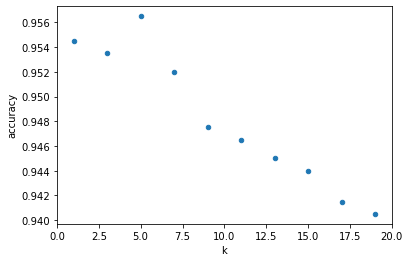

In [16]:
# plot accuracy vs. k
_ = results.plot.scatter(x='k', y='accuracy', xlim=[0, 20])

We choose the best k, which minimizes the misclassification rate in the validation set. Our best k is `k=5`

__7.2.c.__ Show the confusion matrix for the validation data that results from using the best k.

__Answer__ 

In [17]:
# k-NN model for k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_X, train_y)

knnPredOpt = knn.predict(valid_X)
print(confusion_matrix(valid_y, knnPredOpt))
print('Accuracy :', accuracy_score(valid_y, knnPredOpt))

[[1803    4]
 [  83  110]]
Accuracy : 0.9565


__7.2.d.__ Consider the following customer: Age = 40, Experience = 10, Income = 84, Family = 2, CCAvg = 2, Education_1 = 0, Education_2 = 1, Education_3 = 0, Mortgage = 0, Securities Account = 0, CD Account = 0, Online = 1 and Credit Card = 1. Classify the customer using the best k.

__Answer__

In [18]:
# predicted class
knn.predict(newCustomerNorm)

array([0])

In [19]:
# predicted probability
knn.predict_proba(newCustomerNorm)

array([[1., 0.]])

New customer is predicted to not accept a loan offer.

__7.2.e.__ Repartition the data, this time into training, validation, and test sets (50% : 30% : 20%). Apply the k-NN method with the k chosen above. Compare the confusion matrix of the test set with that of the training and validation sets. Comment on the differences and their reason.

__Answer__ 

In [20]:
# partition the data into training (50%), validation (30%) and test (20%) sets
train_df, temp_df = train_test_split(bank_df, test_size=0.5, random_state=1)
valid_df, test_df = train_test_split(temp_df, test_size=0.4, random_state=1)

print('Training : ', train_df.shape)
print('Validation : ', valid_df.shape)
print('Test : ', test_df.shape)

Training :  (2500, 14)
Validation :  (1500, 14)
Test :  (1000, 14)


In [21]:
# normalize training and validation sets. The transformation is trained using the training set only.
# if you don't convert the integer columns to real numbers (float64), 
# the StandardScaler will raise a DataConversionWarning. This is expected
outcome = 'Personal_Loan'
predictors = list(bank_df.columns)
predictors.remove(outcome)

scaler = preprocessing.StandardScaler()
scaler.fit(train_df[predictors])

# Transform the predictors of training validation and newCustomer
train_X = scaler.transform(train_df[predictors])
train_y = train_df[outcome]
valid_X = scaler.transform(valid_df[predictors])
valid_y = valid_df[outcome]
test_X = scaler.transform(test_df[predictors])
test_y = test_df[outcome]
test_X = pd.DataFrame(test_X, columns=['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account',
                                   'CD_Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3'])
test_y = pd.DataFrame(test_y, columns=['Personal_Loan'])

In [22]:
# k-NN model for best k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [23]:
# confusion matrix of training set
knnPredOpt = knn.predict(train_X)
print(confusion_matrix(train_y, knnPredOpt))
print('Accuracy :', accuracy_score(train_y, knnPredOpt))

[[2255    4]
 [  75  166]]
Accuracy : 0.9684


In [24]:
# confusion matrix of validation set
knnPredOpt = knn.predict(valid_X)
print(confusion_matrix(valid_y, knnPredOpt))
print('Accuracy :', accuracy_score(valid_y, knnPredOpt))

[[1346    3]
 [  67   84]]
Accuracy : 0.9533333333333334


In [25]:
# confusion matrix of test set
knnPredOpt = knn.predict(test_X)
print(confusion_matrix(test_y, knnPredOpt))
print('Accuracy :', accuracy_score(test_y, knnPredOpt))

[[907   5]
 [ 35  53]]
Accuracy : 0.96


The error rate increases from the training set to the validation set, but decreases from the validation set to the test set.  The differences are small, but this decreased performance, at least in the test set, is unexpected but we can ignore it as difference is very small - both the training and validation sets are used in setting the optimal k so there can be overfitting.  The test set was not used to select the optimal k.

# Problem 7.3 Predicting Housing Median Prices

The file _BostonHousing.csv_ contains information on over 500 census tracts in Boston, where for each tract multiple variables
are recorded. The last column (CAT. MEDV) was derived from MEDV, such that it obtains the value 1 if MEDV > 30 and 0 otherwise. Consider the goal of predicting the median value (MEDV) of a tract, given the information in the first 12 columns.
Partition the data into training (60%) and validation (40%) sets.

__7.3.a.__ Perform a k-NN prediction with all 12 predictors (ignore the CAT. MEDV column), trying values of k from 1 to 5. Make sure to normalize the data. What is the best k? What does it mean?

__Answer__

#### Data preparation
Load the data and remove unnecessary columns (CAT. MEDV). Split the data into training (60%) and validation (40%) sets (use `random_state=1`).

In [26]:
# Load the data
house_df = pd.read_csv(DATA / 'BostonHousing.csv')

# Drop CAT.MEDV column
house_df = house_df.drop(columns=['CAT. MEDV'])

# Make sure that the result is as expected
house_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [27]:
# split dataset into training (60%) and validation (40%) sets
train_df, valid_df = train_test_split(house_df, test_size=0.4, random_state=1)
print('Training set:', train_df.shape, 'Validation set:', valid_df.shape)

Training set: (303, 13) Validation set: (203, 13)


In [28]:
# normalize training and validation sets. The transformation is trained using the training set only.
# if you don't convert the integer columns to real numbers (float64), the StandardScaler will raise a DataConversionWarning. 
# This is expected
outcome = 'MEDV'
predictors = list(house_df.columns)
predictors.remove(outcome)

scaler = preprocessing.StandardScaler()
scaler.fit(train_df[predictors])

# Transform the predictors of training validation and newCustomer
train_X = scaler.transform(train_df[predictors])
train_y = train_df[outcome]
valid_X = scaler.transform(valid_df[predictors])
valid_y = valid_df[outcome]

In [29]:
# Train a regressor for different values of k
results = []
for k in range(1, 6):
    knn = KNeighborsRegressor(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'RMSE': math.sqrt(mean_squared_error(valid_y, knn.predict(valid_X)))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
results

,k,RMSE
0,1,5.403228
1,2,4.778562
2,3,4.671801
3,4,4.789219
4,5,5.014823


Here best `k = 3`. This means that, for a given record, MEDV is predicted by averaging the MEDVs for the 3 closest records, proximity being measured by the distance between the vectors of predictor values.

__7.3.b.__ Predict the MEDV for a tract with the following information, using the best k:

CRIM = 0.2, ZN = 0, INDUS = 7, CHAS = 0, NOX = 0.538, RM = 6, AGE = 62, DIS = 4.7, RAD = 4, TAX = 307, PTRATIO = 21, LSTAT = 10.

__Answer__

In [30]:
# new tract
newTract = pd.DataFrame([{'CRIM': 0.2, 'ZN': 0, 'INDUS': 7, 'CHAS': 0, 'NOX': 0.538, 'RM': 6, 'AGE': 62, 'DIS': 4.7, 'RAD': 4, 
                          'TAX': 307, 'PTRATIO': 21, 'LSTAT': 10}],
                       columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT'])
newTract

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.2,0,7,0,0.538,6,62,4.7,4,307,21,10


In [31]:
# normalize new record
newTractNorm = pd.DataFrame(scaler.transform(newTract), 
                               columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT'])

newTractNorm

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,-0.403622,-0.481603,-0.620687,-0.293294,-0.153758,-0.358814,-0.243285,0.400608,-0.640284,-0.604731,1.197866,-0.421956


In [32]:
# train knn model with k=3
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(train_X, train_y)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [33]:
# predict value of new tract
knn.predict(newTractNorm)

array([18.76666667])

The predicted price of new tract is $18.77k.

__7.3.c.__ If we used the above k-NN algorithm to score the training data, what would be the error of the training set?

__Answer__

In the training set, the error is zero because the training cases are matched to themselves. 

__7.3.d.__ Why is the validation data error overly optimistic compared to the error rate when applying this k-NN predictor to new data?

__Answer__

The validation error measures the error for the "best k" among multiple k's tried out for the validation data, so that particular k is optimized for the particular validation data set that was used in selecting it. It may not be as suitable for the new data.

__7.3.e.__ If the purpose is to predict MEDV for several thousands of new tracts, what would be the disadvantage of using k-NN prediction? List the operations that the algorithm goes through in order to produce each prediction.

__Answer__

KNN does not yield a uniform rule that can be applied to each new record to be predicted -- the whole "model building" process has to be repeated for each new record to be classified.

Specifically, the algorithm must calculate the distance from a new record to each of the training records, select the n-closest training records, determine the average target value for the n-closest training records, then score that target value to the new record, then repeat this process for each of the new records.